In [6]:
from franke import FrankeFunction
from project1tools import create_data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

In [139]:
# MAKE DATA POINTS FOR VISUAL REPRESENTATION

np.random.seed(2019)
points = 300
noise = 0.05
x = np.random.random(size = points)
y = np.random.random(size = points)
x = x[np.argsort(x)]
y = y[np.argsort(y)]
x, y = np.meshgrid(x,y)
x = x.ravel()
y = y.ravel()
z = FrankeFunction(x,y)
z_noise = z + np.random.normal(0, noise, size = z.shape[0])
x = x.reshape(points,points)
y = y.reshape(points,points)
z = z.reshape(points,points)
z_noise = z_noise.reshape(points,points)

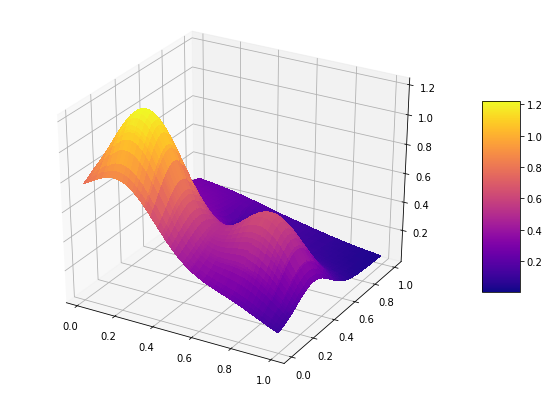

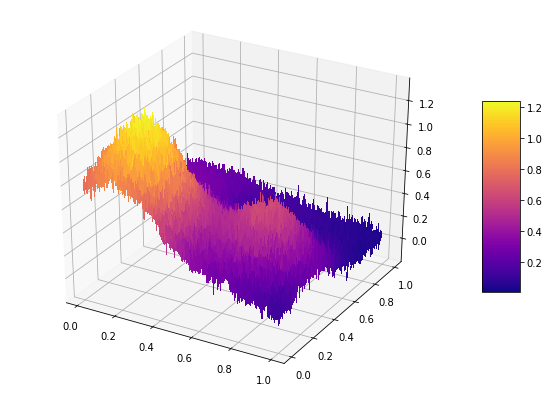

In [140]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap='plasma', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z_noise, cmap='plasma', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [141]:
from sklearn.model_selection import train_test_split
import numpy as np

# CREATE DATA
x = x.ravel()
y = y.ravel()
X = np.c_[x,y]
z = z.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, z, train_size=0.8, test_size=0.2)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]



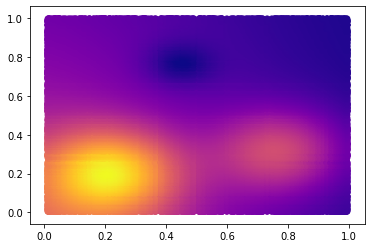

In [142]:
fig = plt.figure()
plt.scatter(x,y,c=z, cmap = 'plasma')
plt.show()

In [143]:
from sklearn.model_selection import KFold
from activation_functions import Activation
from neural_net import Neural_Network

In [149]:
NN = Neural_Network('REGRESSOR', X_train, y_train, ['SIGMOID', 'SIGMOID', 'SIGMOID', 'LINEAR'], 
                                  epochs = 50, batchsize = 200, iterations = None, hidden_layers =3, 
                                  hidden_neurons = [100,50,20], eta = 1e-1, lambd = 0)
NN.train(X_train, y_train)
_, pred = NN.feed_out_regressor(X_test)
R2 = NN.R2score(y_test,pred[-1])
MSE = NN.mse(y_test,pred[-1])
print(R2)
print(MSE)


0.970588959754377
0.0024734601456366735


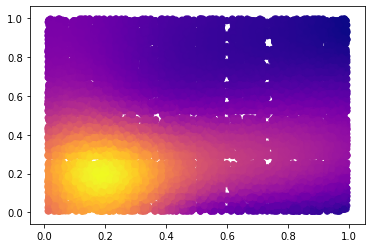

In [145]:
fig = plt.figure()
plt.scatter(X_test[:,0], X_test[:,1], c = pred[-1][:,0], cmap='plasma')
plt.show()

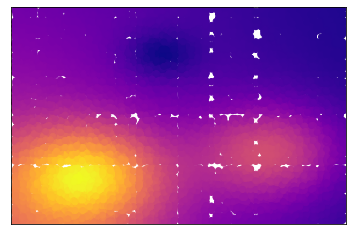

In [146]:
fig = plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c=y_test[:,0], cmap = 'plasma')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.show()


In [150]:


eta_vec = np.logspace(-4, 0, 5)
lam_vec = np.logspace(-4, 0, 5)
test_R2_NN = np.zeros((len(eta_vec), len(lam_vec)))
test_MSE_NN = np.zeros((len(eta_vec), len(lam_vec)))

for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        R2 = 0
        MSE = 0
        for tr_idx, val_idx in kf.split(X_train):          
            NN = Neural_Network('REGRESSOR', X_train[tr_idx], y_train[tr_idx], ['SIGMOID','SIGMOID', 'SIGMOID', 'LINEAR'], 
                                  epochs = 50, batchsize = 200, iterations = None, hidden_layers =3, 
                                  hidden_neurons = [100,50,20], eta = eta, lambd = lam)
            NN.train(X_train[tr_idx], y_train[tr_idx])
            _, pred = NN.feed_out_regressor(X_train[val_idx])
            R2 += NN.R2score(y_train[val_idx],pred[-1])
            MSE += NN.mse(y_train[val_idx],pred[-1])
        R2 = R2/5
        MSE = MSE/5
        test_R2_NN[i][j] = R2
        test_MSE_NN[i][j] = MSE

/Users/douglas/Fall_2019/FYS4155/project2/activation_functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [185]:
updated_R2 = test_R2_NN
updated_MSE = test_MSE_NN
for i in range(test_R2_NN.shape[0]):
    for j in range(test_R2_NN.shape[1]):
        if updated_R2[i][j] < 0:
            updated_R2[i][j] = 'NaN'
for i in range(test_R2_NN.shape[0]):
    for j in range(test_R2_NN.shape[1]):
        if updated_MSE[i][j] >= 1:
            updated_MSE[i][j] = 'NaN'
print(updated_MSE)

[[0.10740446 0.1074372  0.10743649 0.10742957 0.10737502]
 [0.0229876  0.0229885  0.02299749 0.02308833 0.02411295]
 [0.01362239 0.01363434 0.01375338 0.01490493 0.02656512]
 [0.00286978 0.00293233 0.0036679  0.01633342 0.08577914]
 [       nan        nan        nan 0.08674464 0.08686186]]


In [206]:
np.savez('gridsearch', R2=updated_R2, MSE=updated_MSE)
stuff = np.load('gridsearch.npz')
print(stuff['MSE'])

[[0.10740446 0.1074372  0.10743649 0.10742957 0.10737502]
 [0.0229876  0.0229885  0.02299749 0.02308833 0.02411295]
 [0.01362239 0.01363434 0.01375338 0.01490493 0.02656512]
 [0.00286978 0.00293233 0.0036679  0.01633342 0.08577914]
 [       nan        nan        nan 0.08674464 0.08686186]]


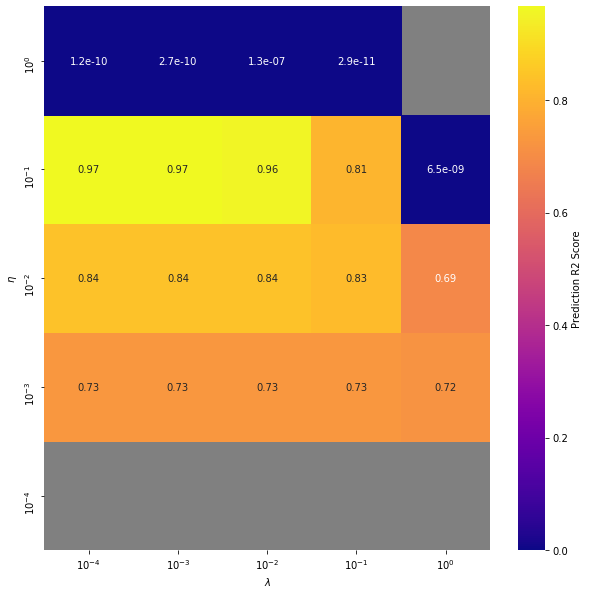

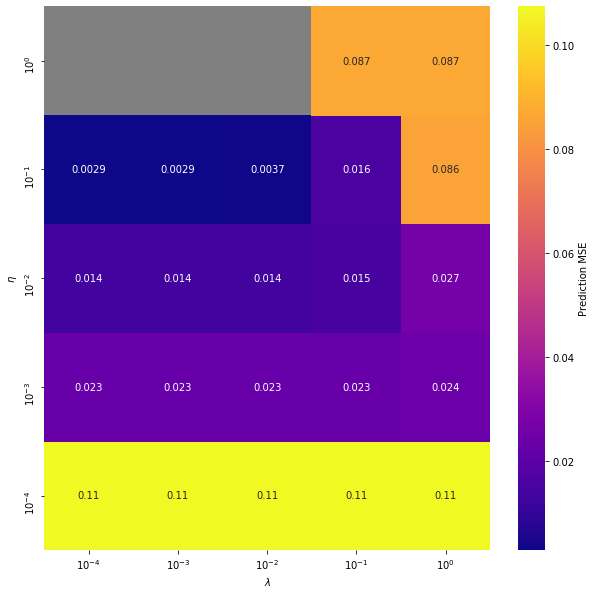

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#PLOT OVER HYPERPARAMETER 10, 10
dummy = np.load('gridsearch.npz')
updated_R2 = dummy['R2']
updated_MSE = dummy['MSE']

labels = ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$',]

fig = plt.figure(figsize = (10, 10))
g = sns.heatmap(updated_R2, annot = updated_R2, cmap="plasma", cbar_kws={'label': 'Prediction R2 Score'})
g.set_facecolor('grey')
g.set_xticklabels(labels)
g.set_yticklabels(labels)
g.set_ylabel("$\eta$")
g.set_xlabel("$\lambda$")
plt.ylim(0,5)
plt.show()

fig = plt.figure(figsize = (10,10))
g = sns.heatmap(updated_MSE, annot = True, cmap = 'plasma', cbar_kws={'label': 'Prediction MSE'})
g.set_facecolor('grey')
g.set_xticklabels(labels)
g.set_yticklabels(labels)
g.set_ylabel("$\eta$")
g.set_xlabel("$\lambda$")
plt.ylim(0,5)
plt.show()

In [190]:
# TESTING DIFFERENT EPOCHS AND BATCH SIZES 100,50,20
epoch_vals = np.concatenate((np.array([1]),np.arange(10,101,10)), axis=0) #1, 10, 20, ...100
batch_vals = [8,16,32,64,128,256] #2^N
MSE_mat = np.zeros((len(epoch_vals),len(batch_vals)))
R2_mat = np.zeros((len(epoch_vals),len(batch_vals)))

for i, batch in enumerate(batch_vals):
    for j, val in enumerate(epoch_vals):
        NN = Neural_Network('REGRESSOR', X_train, y_train, ['SIGMOID', 'SIGMOID', 'SIGMOID', 'LINEAR'], 
                                      epochs = val, batchsize = batch, iterations = None, hidden_layers =3, 
                                      hidden_neurons = [100,50,20], eta = 1e-1, lambd = 10e-4)
        NN.train(X_train, y_train)
        _, pred = NN.feed_out_regressor(X_test)
        R2 = NN.R2score(y_test,pred[-1])
        MSE = NN.mse(y_test,pred[-1])        
        R2_mat[j][i] = R2
        MSE_mat[j][i] = MSE
        

In [207]:
np.savez('batches', R2=R2_mat, MSE=MSE_mat)


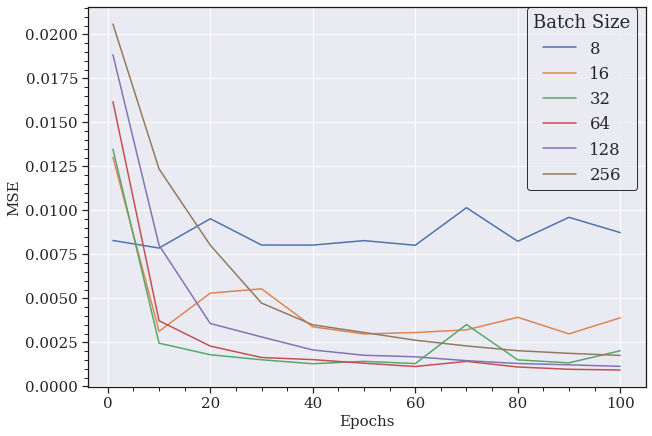

In [191]:
dummy = np.load('batches.npz')
MSE_mat = dummy['MSE']
R2_mat = dummy['R2']
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.5)
sns.set_style('dark',{'axes.edgecolor': '.1','xtick.bottom': True,'ytick.left': True,'axes.grid':True,
                      'grid.color':'white','font.family':['serif'],'font.serif':['serif']})

ax.plot(epoch_vals, MSE_mat[:,0], label = '8')
ax.plot(epoch_vals, MSE_mat[:,1], label = '16')
ax.plot(epoch_vals, MSE_mat[:,2], label = '32')
ax.plot(epoch_vals, MSE_mat[:,3], label = '64')
ax.plot(epoch_vals, MSE_mat[:,4], label = '128')
ax.plot(epoch_vals, MSE_mat[:,5], label = '256')
leg = ax.legend(title = 'Batch Size',bbox_to_anchor=(1, 1.02), fancybox = True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1)
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.minorticks_on()

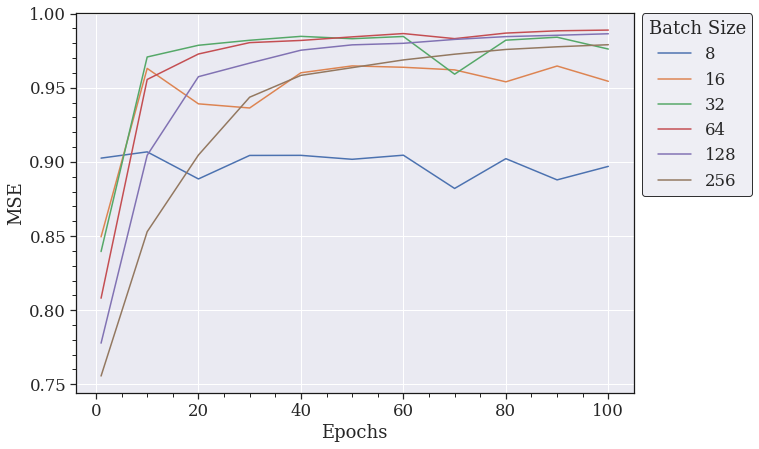

In [192]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.5)
sns.set_style('dark',{'axes.edgecolor': '.1','xtick.bottom': True,'ytick.left': True,'axes.grid':True,
                      'grid.color':'white','font.family':['serif'],'font.serif':['serif']})

ax.plot(epoch_vals, R2_mat[:,0], label = '8')
ax.plot(epoch_vals, R2_mat[:,1], label = '16')
ax.plot(epoch_vals, R2_mat[:,2], label = '32')
ax.plot(epoch_vals, R2_mat[:,3], label = '64')
ax.plot(epoch_vals, R2_mat[:,4], label = '128')
ax.plot(epoch_vals, R2_mat[:,5], label = '256')
leg = ax.legend(title = 'Batch Size',bbox_to_anchor=(1, 1.02), fancybox = True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1)
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.minorticks_on()